importing the data set

In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from anyio.lowlevel import checkpoint

image_size = (180, 180)
batch_size = 128

train_ds = keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

2025-04-05 12:21:48.643695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 12:21:48.654552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743852108.669968   31999 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743852108.672974   31999 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743852108.681552   31999 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found 18323 files belonging to 3 classes.
Using 14659 files for training.


I0000 00:00:1743852274.094920   31999 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 18323 files belonging to 3 classes.
Using 3664 files for validation.


converting the dataset to numpy arrays

In [2]:
def dataset_to_numpy(dataset):
    x = []
    y = []

    for images, labels in dataset:
        x.extend(images.numpy())
        y.extend(labels.numpy())
    return np.array(x), np.array(y)

x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)

2025-04-05 12:26:46.680659: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-05 12:26:50.719057: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
x_train = x_train / 255.0
x_val = x_val / 255.0

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
input_shape = (180, 180, 3)
num_epochs = 10
image_size = 128
patch_size = 6

num_patches = (image_size // patch_size)**2
projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim
]

transformer_layers = 8
mlp_head_units = [
    2048, 1024
]

In [5]:
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.02, width_factor=0.02),
    ], name="data_augmentation"
)

data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)

    return x

In [7]:
class Patches(layers.Layer):
    def __init__(self, num_patches):
        super().__init__()
        self.patch_size = num_patches

    def call(self, images):
        input_shape = keras.ops.shape(images)
        batch_size, height, width, channels = input_shape

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        patches = keras.ops.image.extract_patches(images, size=self.patch_size )
        patches = keras.ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            )
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


I0000 00:00:1743852431.714415   31999 cuda_dnn.cc:529] Loaded cuDNN version 90300


Image size: 128 X 128
Patch size: 6 X 6
Number of patches per images: 441
Elements per patch: 108


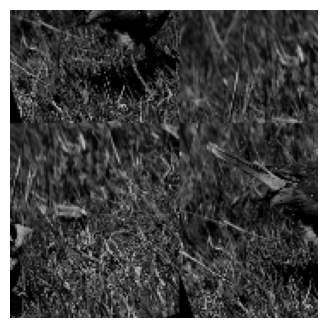

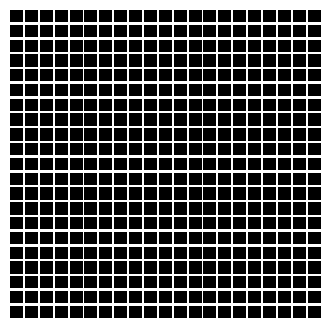

In [8]:

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis('off')

resized_image = keras.ops.image.resize(
    keras.ops.convert_to_tensor([image]),
    size=(image_size, image_size),
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Number of patches per images: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis('off')


In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.projection_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        postition = keras.ops.expand_dims(
            keras.ops.arange(start=0, stop=self.num_patches, step=1),
            axis=0,
        )

        projection_patches = self.projection(patch)
        encoded = projection_patches + self.projection_embedding(postition)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})

        return config



In [10]:
def create_claffifier():
    inputs = keras.Input(shape=input_shape)

    augmentation = data_augmentation(inputs)

    patches = Patches(patch_size)(augmentation)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(100)(features)

    model = keras.Model(inputs=inputs, outputs=logits)

    return model


In [11]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseTopKCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="precision"),
        ]
    )

    checkpoint_filepath = "checkpoint/model.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5 = model.evaluate(x_val, y_val)
    print(f"Accuracy: {accuracy}")
    print(f"Top 5: {top_5}")

    return model


In [ ]:
vit_model = create_claffifier()
history = run_experiment(vit_model)